In [1]:
import numpy as np
import scipy.misc
import glob
import keras
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, Input
from keras.layers import Dense, Dropout, Flatten
from keras.layers.merge import Concatenate
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from io import BytesIO
from IPython import display
from PIL import Image

def display_image(arr):
    b = BytesIO()
    Image.fromarray(np.uint8(arr)).save(b, format='png')
    data = b.getvalue()
    display.display(display.Image(data=data, format='png', embed=True))

labels = ['gyoku', 'ou', 'kin', 'gin', 'kei', 'kyo', 'kaku', 'hi', 'fu', 'narigin', 'narikei', 'narikyo', 'uma', 'ryu', 'to']
num_classes = len(labels) * 2

# input image dimensions
img_rows, img_cols = 64, 64
input_shape = (img_rows, img_cols, 1)

series_imgs = []
series_labels = []
for i, series in enumerate(glob.glob("learn/*.npz")):
    file = np.load(series)
    print(series)
    series_imgs.append(file['imgs'].astype(np.float32))
    series_labels.append(file['labels'])
num_series = len(series_imgs)

Using TensorFlow backend.


learn/21.npz
learn/17.npz
learn/08.npz
learn/09.npz
learn/24.npz
learn/18.npz
learn/06.npz
learn/12.npz
learn/05.npz
learn/16.npz
learn/23.npz
learn/10.npz
learn/01.npz
learn/03.npz
learn/04.npz
learn/14.npz
learn/22.npz
learn/15.npz
learn/20.npz
learn/13.npz
learn/26.npz
learn/25.npz
learn/19.npz
learn/07.npz
learn/11.npz
learn/02.npz
learn/00.npz


In [16]:
# load all
x_all = np.empty((0, img_rows, img_cols))
y_all = np.empty((0, 2), np.int32)
for i in range(num_series):
    num_imgs = len(series_imgs[i])
    x_all = np.r_[x_all, series_imgs[i]]
    label_indices = []
    for j, label in enumerate(series_labels[i]):
        label_indices.append(labels.index(label))
    label_and_series = np.c_[label_indices, np.full((num_imgs), i)]
    y_all = np.r_[y_all, label_and_series]

# rot 180
x_all = np.r_[x_all, np.rot90(x_all, 2, (1, 2))]
y_rot = np.copy(y_all)
y_rot[:, 0] += len(labels)
y_all = np.r_[y_all, y_rot]

# reshape to TF
x_all = x_all.reshape(x_all.shape[0], img_rows, img_cols, 1)
x_all = x_all.astype(np.float32)
x_all /= 255

In [62]:
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.03)

# train_ids = np.where(y_all[:, 1] != 21)
# test_ids = np.where(y_all[:, 1] == 21)
# x_train = x_all[train_ids]
# x_test = x_all[test_ids]
# y_train = y_all[train_ids]
# y_test = y_all[test_ids]
# print(test_ids)
# display_image(np.uint8(x_test[0] * 255)[:, :, 0])

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train[:, 0], num_classes)
y_test = keras.utils.to_categorical(y_test[:, 0], num_classes)

In [48]:
# datagen = ImageDataGenerator(rotation_range=15, zoom_range=0.25)
# datagen.fit(x_train)

# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
# model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

# model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
# model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))

# model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 26, 26, 64)        36928     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 64)        0         
__________

In [63]:
datagen = ImageDataGenerator(rotation_range=15, zoom_range=0.25)
datagen.fit(x_train)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_47 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 12, 12, 128)       73856     
__________

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.fit_generator(datagen.flow(x_train, y_train, batch_size=16), steps_per_epoch=x_train.shape[0],
                    epochs=100, verbose=1, validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/100
719/719 [==============================] - 11s - loss: 3.3665 - acc: 0.0414 - val_loss: 3.1863 - val_acc: 0.0870
Epoch 2/100
719/719 [==============================] - 10s - loss: 2.6654 - acc: 0.1672 - val_loss: 2.0201 - val_acc: 0.3043
Epoch 3/100
719/719 [==============================] - 10s - loss: 2.0396 - acc: 0.3134 - val_loss: 1.3572 - val_acc: 0.5652
Epoch 4/100
719/719 [==============================] - 10s - loss: 1.5695 - acc: 0.4600 - val_loss: 0.8823 - val_acc: 0.7391
Epoch 5/100
719/719 [==============================] - 10s - loss: 1.2543 - acc: 0.5651 - val_loss: 0.6814 - val_acc: 0.7826
Epoch 6/100
719/719 [==============================] - 10s - loss: 1.0034 - acc: 0.6433 - val_loss: 0.5797 - val_acc: 0.7391
Epoch 7/100
719/719 [==============================] - 10s - loss: 0.8396 - acc: 0.6955 - val_loss: 0.4100 - val_acc: 0.8261
Epoch 8/100
719/719 [==============================] - 10s - loss: 0.7113 - acc: 0.7388 - val_loss: 0.4138 - val_acc: 0.8696


In [59]:
pred_res = model.predict(x_test)
res = np.array([np.argmax(r) for r in pred_res])
ans = np.array([np.where(y == 1)[0][0] for y in y_test])
print(res)
print(ans)
correct = np.where(res == ans)[0]
errors = np.where(res != ans)[0]
print(errors)

[16 22 26 14  6 26 14  8 29  1 13 19  0 27 14  1  0 23  7 17 22 10 10]
[16 22 26 14  6 26 14  8 29  1 13 19  0 27 14  1  0 23  7 17 22  9 10]
[21]


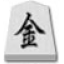

narikei


In [60]:
for e in errors:
    display_image(np.uint8(x_test[e] * 255)[:, :, 0])
    if len(labels) > res[e]:
        print(labels[res[e]])
    else:
        print("p")
        print(labels[res[e] - len(labels)])

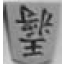

*ou


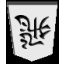

*hi


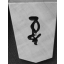

*narikyo


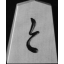

to


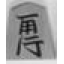

kaku


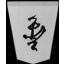

*narikyo


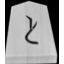

to


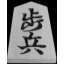

fu


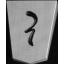

*to


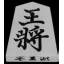

ou


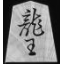

ryu


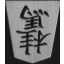

*kei


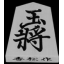

gyoku


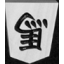

*uma


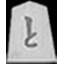

to


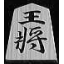

ou


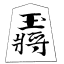

gyoku


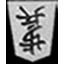

*fu


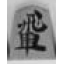

hi


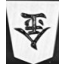

*kin


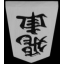

*hi


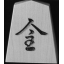

narikei


In [61]:
for e in correct:
    display_image(np.uint8(x_test[e] * 255)[:, :, 0])
    if len(labels) > res[e]:
        print(labels[res[e]])
    else:
        print("*" + labels[res[e] - len(labels)])